<a href="https://colab.research.google.com/github/huranokuma/simple_dcgan_test/blob/main/dcgan_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 画像の収集

### googleimagedownloadとChromeDriverのインストール

In [1]:
!git clone https://github.com/Joeclinton1/google-images-download.git gid-joeclinton
!pip install -e gid-joeclinton

Cloning into 'gid-joeclinton'...
remote: Enumerating objects: 724, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 724 (delta 34), reused 47 (delta 29), pack-reused 666
Receiving objects: 100% (724/724), 335.70 KiB | 16.78 MiB/s, done.
Resolving deltas: 100% (424/424), done.
Obtaining file:///content/gid-joeclinton
     |████████████████████████████████| 979 kB 29.9 MB/s 
     |████████████████████████████████| 359 kB 70.0 MB/s 
     |████████████████████████████████| 138 kB 75.9 MB/s 
     |████████████████████████████████| 55 kB 5.4 MB/s 
     |████████████████████████████████| 4.0 MB 77.7 MB/s 
     |████████████████████████████████| 58 kB 8.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Running setup.py develop for google-images-download
ERROR: pip's dependency resolver does not currently take in

In [2]:
!apt update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net

### Google Driveのマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 画像を収集してGoogle Drive内に保存する

In [12]:
import os
DIR = "drive/MyDrive/Colab Notebooks/dcgan/img"
if(os.path.isdir(DIR)==False):
  os.mkdir(DIR)
  print("==made DIR==")
else:
  print("==DIR already exists==")

==DIR already exists==


In [ ]:
!googleimagesdownload --keywords "泉砂霧,北山雫,小鳥遊六花,ゆのはなゆうな,南ことり,雪ノ下雪乃,本間芽衣子,四宮かぐや,御坂美琴,小野寺小咲,秋山雫,樋口円薫" -o "/content/drive/MyDrive/Colab Notebooks/dcgan/img" -l 25 -f "jpg" --chromedriver /usr/bin/chromedriver
# 検索したい言葉を""の中に入れる"
# デフォルトでは集めてきた画像をGoogle Colabのフォルダ内に保存する

## Ganの訓練

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-b56d401d-4ada-16d7-1f7a-8758d65b82a0)


In [3]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, 
                              DataLoader,
                              TensorDataset)
import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

In [4]:
img_data = ImageFolder("/content/drive/MyDrive/Colab Notebooks/dcgan/img",
    transform=transforms.Compose([
        transforms.Resize(80),
        transforms.CenterCrop(64),#画像を64pxにする
        transforms.ToTensor()
]))

batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)

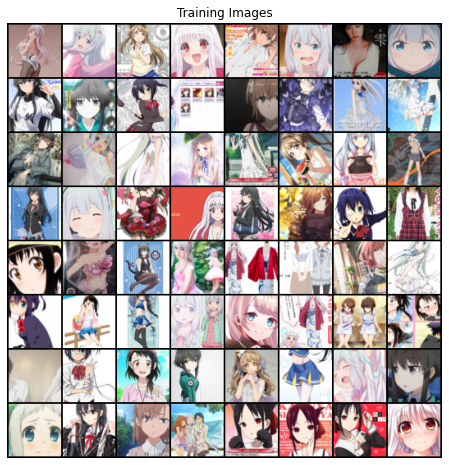

In [5]:
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# 訓練用の画像の何枚かを表示する
real_batch = next(iter(img_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to("cuda:0")[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [6]:
nz = 100
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.main(x)
        return out

In [7]:
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

In [8]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adamのパラメータは元論文の提案値
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# クロスエントロピーを計算するための補助変数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

In [9]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 生成モデル、識別モデルの目的関数の追跡用の配列
    log_loss_g = []
    log_loss_d = []
    for real_img, _ in tqdm.tqdm(loader):
        batch_len = len(real_img)
        
         # 実際の画像をGPUにコピー
        real_img = real_img.to("cuda:0")
        
         # 偽画像を乱数と生成モデルから作る
         # これを用いることであとでモデルから関数として画像を次々と生み出すことができる？
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 後で使用するので偽画像の値のみ取り出しておく
        fake_img_tensor = fake_img.detach()
        
        # 偽画像に対する生成モデルの評価関数を計算する
        out = d(fake_img)
        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        # 計算グラフが生成モデルと識別モデルの両方に
        # 依存しているので両者とも勾配をクリアしてから
        # 微分の計算とパラメータ更新を行う
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()

        # 実際の画像に対する識別モデルの評価関数を計算
        real_out = d(real_img)
        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorchでは同じTensorを含んだ計算グラフに対して
        # 2回backwardを行うことができないので保存してあった
        # Tensorを使用して無駄な計算を省く
        fake_img = fake_img_tensor
        
        # 偽画像に対する識別モデルの評価関数の計算
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 実偽の評価関数の合計値
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 識別モデルの微分計算とパラメータ更新
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()
        
    return mean(log_loss_g), mean(log_loss_d)

In [14]:
import os
if(os.path.isdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result")==False):
  os.mkdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result")
  print("==made dcgan/result!==")

if(os.path.isdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/g")==False):
  os.mkdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/g")
  print("==made dcgan/result/g!==")

if(os.path.isdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/d")==False):
  os.mkdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/d")
  print("==made dcgan/result/d!==")

if(os.path.isdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/img_raw")==False):
  os.mkdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/img_raw")  
  print("==made result/img_raw!==")
  
if(os.path.isdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/img")==False):
  os.mkdir("/content/drive/MyDrive/Colab Notebooks/dcgan/result/img")  
  print("==made result/img!==")

==made dcgan/result!==
==made dcgan/result/g!==
==made dcgan/result/d!==
==made result/img_raw!==
==made result/img!==


In [ ]:
from IPython.display import Image,display_jpeg
num_epochs=10000 #@param {type:"number"}
for epoch in range(num_epochs):
    train_dcgan(g, d, opt_g, opt_d, img_loader)
    # 10回の繰り返しごとにモデルを保存する
    if epoch % 10 == 0:
        # モニタリング用のzから生成した画像を保存
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "/content/drive/MyDrive/Colab Notebooks/dcgan/result/img_raw/{:03d}.jpg".format(epoch))
    display_jpeg(Image("/content/drive/MyDrive/Colab Notebooks/dcgan/result/img_raw/{:03d}.jpg".format(epoch)))
    if epoch % 100 == 0:
        # パラメータの保存
        torch.save(
            g.state_dict(),
            "/content/drive/MyDrive/Colab Notebooks/dcgan/result/g/g_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        torch.save(
            d.state_dict(),
            "/content/drive/MyDrive/Colab Notebooks/dcgan/result/d/d_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        for i in range(64):
            save_image(generated_img[i],
                       f"/content/drive/MyDrive/Colab Notebooks/dcgan/result/img/{epoch}_{i}.jpg")  

NameError: ignored